# **Import**

In [1]:
# Step 1: Download CUDA installer for Linux
# Replace <CUDA_version> with the version you want to install (e.g., 11.0)
!wget https://developer.download.nvidia.com/compute/cuda/<CUDA_version>/local_installers/cuda_<CUDA_version>_linux.run

# Step 2: Make installer executable and run
!chmod +x cuda_<CUDA_version>_linux.run
!sudo ./cuda_<CUDA_version>_linux.run --silent --override

# Step 3: Update environment variables
# import os
# os.environ['PATH'] += ":/usr/local/cuda/bin"
# os.environ['LD_LIBRARY_PATH'] += ":/usr/local/cuda/lib64"

# # Step 4: Verify installation
!nvcc --version
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'



/bin/bash: line 1: CUDA_version: No such file or directory
/bin/bash: line 1: CUDA_version: No such file or directory
/bin/bash: line 1: CUDA_version: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
import torchvision
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
np.random.seed(42)
torch.manual_seed(42)
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split trainset into train and validation sets
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:12<00:00, 13156107.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Attack Using FGSM**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        # Load the pre-trained resnext50_32x4d model
        self.resnext = models.resnext50_32x4d(pretrained=True)

        # Modify the head of the model
        num_features = self.resnext.fc.in_features
        self.resnext.fc = nn.Identity()  # Remove the fully connected layer

        # Define the head of the model
        self.head = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, x):
        # Forward pass through the modified resnext50_32x4d model
        x = self.resnext(x)
        # Forward pass through the head of the model
        x = self.head(x)
        return x

# Instantiate the model
modelF = NetF()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 180MB/s]


In [6]:
def fit(model, device, train_loader, val_loader, epochs):
    data_loader = {'train': train_loader, 'val': val_loader}
    print("Fitting the model...")
    train_loss, val_loss = [], []
    train_accuracies, test_losses, test_accuracies = [], [], []
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0
        correct_train, correct_val, total_train, total_val = 0, 0, 0, 0

        for phase in ('train', 'val'):
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for i, data in enumerate(data_loader[phase]):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    loss_per_epoch += loss.item() * inputs.size(0)
                    _, predicted_train = torch.max(outputs, 1)
                    correct_train += (predicted_train == labels).sum().item()
                    total_train += labels.size(0)
                else:
                    val_loss_per_epoch += loss.item() * inputs.size(0)
                    _, predicted_val = torch.max(outputs, 1)
                    correct_val += (predicted_val == labels).sum().item()
                    total_val += labels.size(0)

        scheduler.step(val_loss_per_epoch / len(val_loader.dataset))

        train_accuracy = correct_train / total_train
        val_accuracy = correct_val / total_val

        train_accuracies.append(train_accuracy)
        test_losses.append(val_loss_per_epoch / len(val_loader.dataset))
        test_accuracies.append(val_accuracy)

        print("Epoch: {} Loss: {:.4f} Val_Loss: {:.4f} Train_Accuracy: {:.4f} Val_Accuracy: {:.4f}".format(epoch+1, loss_per_epoch / len(train_loader.dataset), val_loss_per_epoch / len(val_loader.dataset), train_accuracy, val_accuracy))

        train_loss.append(loss_per_epoch / len(train_loader.dataset))
        val_loss.append(val_loss_per_epoch / len(val_loader.dataset))

    return train_loss, val_loss, train_accuracies, test_losses, test_accuracies


In [7]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
modelF.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelF.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Define the number of epochs
epochs = 10

# Call the fit function to train the model
train_loss, val_loss, train_accuracies, test_losses, test_accuracies = fit(modelF, device, trainloader, valloader, epochs)

Fitting the model...
Epoch: 1 Loss: 1.4483 Val_Loss: 0.8790 Train_Accuracy: 0.4813 Val_Accuracy: 0.7206


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 Loss: 0.8738 Val_Loss: 0.7031 Train_Accuracy: 0.7372 Val_Accuracy: 0.7725
Epoch: 3 Loss: 0.7206 Val_Loss: 0.7324 Train_Accuracy: 0.7834 Val_Accuracy: 0.7657
Epoch: 4 Loss: 0.6067 Val_Loss: 0.6397 Train_Accuracy: 0.8188 Val_Accuracy: 0.7939
Epoch: 5 Loss: 0.5564 Val_Loss: 0.6968 Train_Accuracy: 0.8337 Val_Accuracy: 0.7823
Epoch: 6 Loss: 0.4961 Val_Loss: 0.6862 Train_Accuracy: 0.8516 Val_Accuracy: 0.7852
Epoch: 7 Loss: 0.4445 Val_Loss: 0.6567 Train_Accuracy: 0.8663 Val_Accuracy: 0.8001
Epoch: 8 Loss: 0.4263 Val_Loss: 0.5811 Train_Accuracy: 0.8738 Val_Accuracy: 0.8130
Epoch: 9 Loss: 0.3673 Val_Loss: 0.6094 Train_Accuracy: 0.8899 Val_Accuracy: 0.8149
Epoch: 10 Loss: 0.3493 Val_Loss: 0.6232 Train_Accuracy: 0.8966 Val_Accuracy: 0.8038


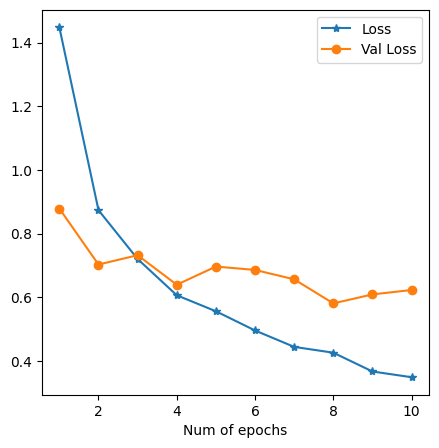

In [8]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), train_loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [9]:
import torch

def calculate_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during inference
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Assuming model, trainloader, valloader, testloader, and device are defined
train_accuracy = calculate_accuracy(modelF, trainloader, device)
val_accuracy = calculate_accuracy(modelF, valloader, device)
test_accuracy = calculate_accuracy(modelF, testloader, device)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Training Accuracy: 0.90
Validation Accuracy: 0.80
Test Accuracy: 0.79


In [10]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [15]:
import random

def test_model(model, dataset, epsilons, num_random_images, attack_type='fgsm'):
    model.eval()
    for epsilon in epsilons:
        correct_clean = 0
        correct_adv = 0
        total = 0

        for _ in range(num_random_images):
            # Randomly select a batch of images and labels from the dataset
            inputs, labels = next(iter(dataset))

            inputs, labels = inputs.cuda(), labels.cuda()  # Assuming CUDA is available

            # Generate adversarial perturbation
            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            data_grad = inputs.grad.data
            if attack_type == 'fgsm':
                perturbed_inputs = fgsm_attack(inputs, epsilon, data_grad)
            elif attack_type == 'ifgsm':
                perturbed_inputs = ifgsm_attack(inputs, epsilon, data_grad)
            elif attack_type == 'mifgsm':
                perturbed_inputs = mifgsm_attack(inputs, epsilon, data_grad)

            # Evaluate clean images
            outputs_clean = model(inputs)
            _, predicted_clean = torch.max(outputs_clean, 1)
            correct_clean += (predicted_clean == labels).sum().item()

            # Evaluate adversarial images
            outputs_adv = model(perturbed_inputs)
            _, predicted_adv = torch.max(outputs_adv, 1)
            correct_adv += (predicted_adv == labels).sum().item()

            total += labels.size(0)

        clean_accuracy = 100 * correct_clean / (num_random_images)
        adv_accuracy = 100 * correct_adv / (num_random_images)

        print(f'Epsilon: {epsilon}\tTest Accuracy = {correct_adv + correct_clean} / {(num_random_images)} = {((correct_adv + correct_clean) / (num_random_images)):.2f}%')


In [12]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'fgsm'
num_random_images = 10

# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.007	Test Accuracy = 780 / 10 = 78.00%
Epsilon: 0.01	Test Accuracy = 750 / 10 = 75.00%
Epsilon: 0.02	Test Accuracy = 740 / 10 = 74.00%
Epsilon: 0.03	Test Accuracy = 710 / 10 = 71.00%
Epsilon: 0.05	Test Accuracy = 680 / 10 = 68.00%
Epsilon: 0.1	Test Accuracy = 600 / 10 = 60.00%
Epsilon: 0.2	Test Accuracy = 580 / 10 = 58.00%
Epsilon: 0.3	Test Accuracy = 550 / 10 = 55.00%


In [13]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'ifgsm'

# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.007	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.01	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.02	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.03	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.05	Test Accuracy = 790 / 10 = 79.00%
Epsilon: 0.1	Test Accuracy = 750 / 10 = 75.00%
Epsilon: 0.2	Test Accuracy = 740 / 10 = 74.00%
Epsilon: 0.3	Test Accuracy = 710 / 10 = 71.00%


In [16]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'mifgsm'
num_random_images = 10

# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.007	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.01	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.02	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.03	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.05	Test Accuracy = 790 / 10 = 79.00%
Epsilon: 0.1	Test Accuracy = 750 / 10 = 75.00%
Epsilon: 0.2	Test Accuracy = 740 / 10 = 74.00%
Epsilon: 0.3	Test Accuracy = 710 / 10 = 71.00%


#  **Defense Against FGSM**

In [17]:
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models

class NetF1(nn.Module):
    def __init__(self, num_classes=10):
        super(NetF1, self).__init__()
        # Load the pre-trained resnet101 model
        self.resnet = models.resnet101(pretrained=True)

        # Add the specified convolutional layer
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        # Modify the head of the model
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer

        # Define the head of the model
        self.head = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # Output layer
        )

    def forward(self, x):
        # Forward pass through the modified resnet101 model
        x = self.resnet(x)
        # Forward pass through the head of the model
        x = self.head(x)
        return x

# Instantiate the model
modelF1 = NetF1()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 82.0MB/s]


In [22]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [21]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [23]:
def defense(device, train_loader, val_loader, test_loader, epochs, Temp, epsilons):

    modelF1 = NetF1().to(device)

    optimizerF1 = optim.Adam(modelF1.parameters(), lr=0.0001, betas=(0.9, 0.999))
    schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

    print("For ModelF:")
    modelF = NetF().to(device)
    optimizerF = optim.Adam(modelF.parameters(), lr=0.0001, betas=(0.9, 0.999))
    schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

    criterion = nn.CrossEntropyLoss()

    # Train modelF with or without adversarial examples
    lossF, val_lossF = fit(modelF, device, optimizerF, schedulerF, criterion, train_loader, val_loader, Temp, epochs)
    fig = plt.figure(figsize=(5, 5))
    plt.plot(np.arange(1, epochs + 1), lossF, "*-", label="Loss")
    plt.plot(np.arange(1, epochs + 1), val_lossF, "o-", label="Val Loss")
    plt.title("Network F(Student Model)")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    # Convert target labels to soft labels for modelF
    for data in train_loader:
        input, label = data[0].to(device), data[1].to(device)
        softlabel = F.log_softmax(modelF(input), dim=1)
        data[1] = softlabel
    print("For ModelF1:")
    # Train modelF1 with or without adversarial examples
    lossF1, val_lossF1 = fit(modelF1, device, optimizerF1, schedulerF1, criterion, train_loader, val_loader, Temp,
                             epochs)
    fig = plt.figure(figsize=(5, 5))
    plt.plot(np.arange(1, epochs + 1), lossF1, "*-", label="Loss")
    plt.plot(np.arange(1, epochs + 1), val_lossF1, "o-", label="Val Loss")
    plt.title("Network F1(Teacher Model)'")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    return modelF, modelF1

For ModelF:
Fitting the model...
Epoch: 1 Loss: 1.8887112800598145 Val_Loss: 1.4128563107958265
Epoch: 2 Loss: 1.0522978293418885 Val_Loss: 0.879371726209191
Epoch: 3 Loss: 0.6778419564247131 Val_Loss: 0.7965067108725287
Epoch: 4 Loss: 0.48701005811691284 Val_Loss: 0.7093546437989374
Epoch: 5 Loss: 0.3568030676007271 Val_Loss: 0.7845330933097062
Epoch: 6 Loss: 0.2875009468078613 Val_Loss: 0.7560921000067595
Epoch: 7 Loss: 0.21787897408604623 Val_Loss: 0.7588667328570299
Epoch: 8 Loss: 0.18485085762143136 Val_Loss: 0.7971668927722676
Epoch: 9 Loss: 0.10599615490585565 Val_Loss: 0.7531088853527785
Epoch: 10 Loss: 0.07628732315152884 Val_Loss: 0.7745379739126582


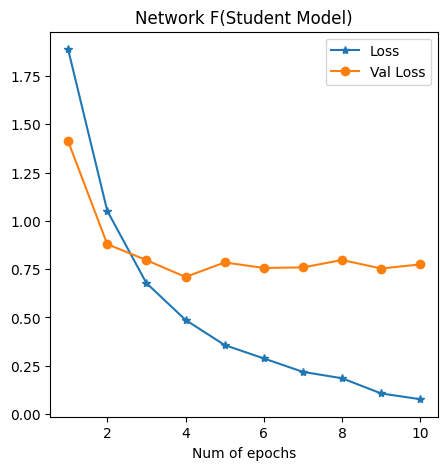

For ModelF1:
Fitting the model...
Epoch: 1 Loss: 1.9018007793426515 Val_Loss: 1.5027036408709873
Epoch: 2 Loss: 1.1874212250709533 Val_Loss: 0.9862161673557986
Epoch: 3 Loss: 0.7325245930671692 Val_Loss: 0.7870732536361476
Epoch: 4 Loss: 0.47329398555755614 Val_Loss: 0.7199431226891317
Epoch: 5 Loss: 0.31851838479042055 Val_Loss: 0.7266697513449724
Epoch: 6 Loss: 0.23120535856485366 Val_Loss: 0.6978752381482701
Epoch: 7 Loss: 0.171420423707366 Val_Loss: 0.799687530679308
Epoch: 8 Loss: 0.1422176325455308 Val_Loss: 0.8629511966826809
Epoch: 9 Loss: 0.11330130611881614 Val_Loss: 0.8222033646266171
Epoch: 10 Loss: 0.08920305793955922 Val_Loss: 0.8682033296223659


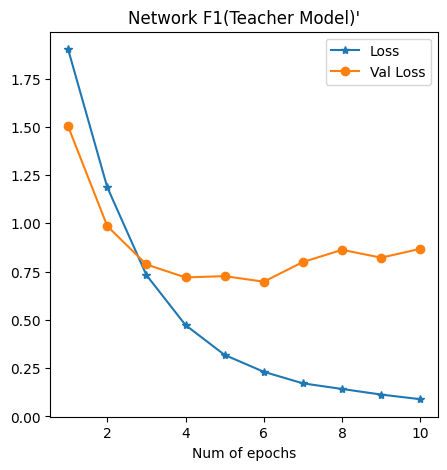

In [24]:
# Define the parameters
Temp = 100
epochs = 10
epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]

# Call the defense function and store the returned models
modelF, modelF1 = defense(device, trainloader, valloader, testloader, epochs, Temp, epsilons)

### Teacher Model

In [25]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'fgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF1, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.007	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.01	Test Accuracy = 810 / 10 = 81.00%
Epsilon: 0.02	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.03	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.05	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.1	Test Accuracy = 790 / 10 = 79.00%
Epsilon: 0.2	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.3	Test Accuracy = 800 / 10 = 80.00%


In [26]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'ifgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF1, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.007	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.01	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.02	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.03	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.05	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.1	Test Accuracy = 810 / 10 = 81.00%
Epsilon: 0.2	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.3	Test Accuracy = 800 / 10 = 80.00%


In [27]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'mifgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF1, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.007	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.01	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.02	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.03	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.05	Test Accuracy = 820 / 10 = 82.00%
Epsilon: 0.1	Test Accuracy = 810 / 10 = 81.00%
Epsilon: 0.2	Test Accuracy = 800 / 10 = 80.00%
Epsilon: 0.3	Test Accuracy = 800 / 10 = 80.00%


### Student Model

In [29]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'fgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.007	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.01	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.02	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.03	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.05	Test Accuracy = 860 / 10 = 86.00%
Epsilon: 0.1	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.2	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.3	Test Accuracy = 870 / 10 = 87.00%


In [30]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'ifgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.007	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.01	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.02	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.03	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.05	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.1	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.2	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.3	Test Accuracy = 870 / 10 = 87.00%


In [31]:
# Test the model with different epsilon values
epsilon_values = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
attack_type = 'mifgsm'
num_random_images = 10
# Call the test_model function with the updated parameters
test_model(modelF, testloader, epsilon_values, num_random_images, attack_type)

Epsilon: 0	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.007	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.01	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.02	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.03	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.05	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.1	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.2	Test Accuracy = 870 / 10 = 87.00%
Epsilon: 0.3	Test Accuracy = 870 / 10 = 87.00%


### Saving the model

In [32]:
import torch

# Save modelF
torch.save(modelF.state_dict(), 'modelF.pth')

# Save modelF1
torch.save(modelF1.state_dict(), 'modelF1.pth')

# **CW Attack Breaking the defence**

In [ ]:
# Initialize modelF and load the state dictionary
modelF = NetF().to(device)
modelF.load_state_dict(torch.load('modelF.pth'))

# Initialize modelF1 and load the state dictionary
modelF1 = NetF1().to(device)
modelF1.load_state_dict(torch.load('modelF1.pth'))


In [ ]:
# Function to load CIFAR-10 dataset
def load_cifar10(batch_size_train=64, batch_size_test=1000):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=False)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes


In [ ]:
# Function to perform Carlini-Wagner attack
def carlini_wagner_attack(model, imgs, labels, epsilon=0.01, confidence=0, max_iterations=100, initial_lr=0.01):
    device = imgs.device
    batch_size = imgs.size(0)

    # Initialize perturbation
    delta = torch.zeros_like(imgs, requires_grad=True).to(device)

    # Define C&W loss function
    def cw_loss(output, target, confidence):
        target_one_hot = F.one_hot(target, num_classes=output.shape[-1]).float().to(device)
        target_one_hot = target_one_hot.unsqueeze(1)

        # Calculating the logits of the target class
        target_logits = torch.sum(target_one_hot * output, dim=-1)

        # Calculating the logits of the other classes
        other_logits = torch.max((1 - target_one_hot) * output - target_one_hot * 10000, dim=-1)[0]

        # CW loss function
        loss = torch.max(target_logits - other_logits + confidence, torch.tensor(0.0).to(device))
        return loss.mean()

    # Adam optimizer for updating the perturbation
    optimizer = optim.Adam([delta], lr=initial_lr)

    for iteration in range(max_iterations):
        # Generate adversarial images
        adv_imgs = imgs + torch.tanh(delta)
        adv_imgs = torch.clamp(adv_imgs, 0, 1)

        # Forward pass to get model predictions
        preds = model(adv_imgs)

        # Calculate C&W loss
        loss = cw_loss(preds, labels, confidence)

        # Backward pass to compute gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clip perturbation
        delta.data = torch.clamp(delta.data, -epsilon, epsilon)

    # Return adversarial examples
    adv_imgs = imgs + torch.tanh(delta)
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    return adv_imgs.detach()


In [ ]:
# Select a sample from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Assuming the target label is 'bird' (class label 2)
target_label = torch.tensor([2])
